In [2]:
!pip install pyxdf
!pip install mne
!pip install pandas
!pip install --upgrade jupyterlab ipympl ipywidgets

In [3]:
import sys
print(sys.version)

3.11.13 (main, Sep 22 2025, 18:50:24) [Clang 17.0.0 (clang-1700.0.13.5)]


In [4]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mne
import pandas as pd
import os

In [76]:
csv_data = pd.read_csv('data/nani_n170.csv')
# csv_data = pd.read_csv('data/nani_n400.csv')
csv_data.head()

,timestamp_iso,trial_index,image_file,class,scrambled,marker_code,resp_key,correct,rt_ms,stim_time_s,isi_s,shown_width_units,shown_height_units
0,2025-10-23T08:33:26.152,1,car_17.jpg,car,0,57,right,1,1353.36,0.3,1.155,1.0500,0.6
1,2025-10-23T08:33:27.750,2,car_32.jpg,car,0,72,right,1,924.69,0.3,1.289,0.8514,0.6
2,2025-10-23T08:33:29.265,3,scrambled_car_27.jpg,car,1,167,left,1,605.82,0.3,1.199,0.8681,0.6
3,2025-10-23T08:33:30.799,4,scrambled_face_33.jpg,face,1,133,left,1,588.47,0.3,1.216,0.5806,0.6
4,2025-10-23T08:33:32.313,5,car_37.jpg,car,0,77,right,1,758.31,0.3,1.192,0.8393,0.6


In [77]:
scrambled_idx = csv_data[csv_data['scrambled'] == 0].index.values
unscrambled_idx = csv_data[csv_data['scrambled'] == 1].index.values

In [78]:
scrambled_idx, unscrambled_idx

(array([  0,   1,   4,   6,   8,   9,  10,  19,  21,  22,  23,  24,  25,
         27,  28,  30,  33,  34,  37,  38,  42,  45,  46,  47,  48,  50,
         51,  55,  57,  58,  60,  62,  64,  66,  67,  70,  73,  75,  76,
         77,  80,  83,  84,  85,  87,  90,  92,  97,  98, 101, 103, 104,
        109, 111, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128,
        129, 131, 138, 141, 142, 143, 145, 147, 151, 152, 153, 154, 157,
        158, 159]),
 array([  2,   3,   5,   7,  11,  12,  13,  14,  15,  16,  17,  18,  20,
         26,  29,  31,  32,  35,  36,  39,  40,  41,  43,  44,  49,  52,
         53,  54,  56,  59,  61,  63,  65,  68,  69,  71,  72,  74,  78,
         79,  81,  82,  86,  88,  89,  91,  93,  94,  95,  96,  99, 100,
        102, 105, 106, 107, 108, 110, 112, 113, 114, 115, 116, 121, 130,
        132, 133, 134, 135, 136, 137, 139, 140, 144, 146, 148, 149, 150,
        155, 156]))

In [101]:
faces_idx = csv_data[csv_data['class'] == 'car'].index.values
cars_idx = csv_data[csv_data['class'] == 'face'].index.values
faces_idx = np.intersect1d(unscrambled_idx, faces_idx)
cars_idx = np.intersect1d(unscrambled_idx, cars_idx)

In [102]:
xdf_path = './data/nani_n170.xdf'
xdf_data = pyxdf.load_xdf(xdf_path)[0]
markers = xdf_data[0]
eeg = xdf_data[4]

Stream 1: Calculated effective sampling rate 0.0000 Hz is different from specified rate 250.0000 Hz.
Stream 3: Calculated effective sampling rate 0.0000 Hz is different from specified rate 250.0000 Hz.
Stream 4: Calculated effective sampling rate 0.0000 Hz is different from specified rate 250.0000 Hz.


In [103]:
# Redefine for Luka's data
# xdf_path = './data/luka_n400.xdf'
# xdf_data = pyxdf.load_xdf(xdf_path)[0]
# markers = xdf_data[0]
# eeg = xdf_data[1]

In [104]:
# Read marker data
marker_time = markers['time_stamps']
time_offset = marker_time[0]
marker_time = marker_time - time_offset
marker_data = [x[0] for x in markers['time_series']]

In [105]:
# n400_data = ExperimentData('data/nani_n400.xdf')

In [106]:
CONST_OFFSET = 0.073  # Delay measured with photodiode that day

In [107]:
eeg_time = eeg['time_stamps']
eeg_time = eeg_time - time_offset - CONST_OFFSET
eeg_data = eeg['time_series'][:, :8]

In [108]:
# Create raw data
info = mne.create_info(ch_names=['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8'], ch_types=['eeg'] * 8,
                       sfreq=250)
raw = mne.io.RawArray([1e-6 * eeg_data[:, i] for i in range(8)], info)
raw.notch_filter(freqs=[50])
raw.filter(0.5, 30)
raw

Creating RawArray with float64 data, n_channels=8, n_times=89971
    Range : 0 ... 89970 =      0.000 ...   359.880 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband att

<RawArray | 8 x 89971 (359.9 s), ~5.5 MiB, data loaded>

In [109]:
TARGET_MARKER = 1
RESPONSE_MARKER = 2

In [110]:
events = []
for i, marker in enumerate(marker_data):
    eeg_start_index = np.argmax(eeg_time >= marker_time[i]) - 1
    events.append([eeg_start_index, 0, marker])
events = np.array(events)

In [111]:
events

array([[11383,     0,    57],
       [11744,     0,   201],
       [11748,     0,    72],
       [12143,     0,   201],
       [12147,     0,   167],
       [12522,     0,   201],
       [12527,     0,   133],
       [12905,     0,   201],
       [12909,     0,    77],
       [13284,     0,   201],
       [13288,     0,   145],
       [13654,     0,   201],
       [13662,     0,    35],
       [14016,     0,   201],
       [14020,     0,   105],
       [14415,     0,   201],
       [14420,     0,     4],
       [14799,     0,   201],
       [14803,     0,     5],
       [15194,     0,   201],
       [15198,     0,    28],
       [15572,     0,   201],
       [15577,     0,   116],
       [15972,     0,   201],
       [15976,     0,   137],
       [16339,     0,   201],
       [16342,     0,   123],
       [16696,     0,   201],
       [16700,     0,   159],
       [17075,     0,   201],
       [17079,     0,   173],
       [17428,     0,   201],
       [17433,     0,   176],
       [17

In [112]:
# Event codes (ERP CORE)
CODES_FACE_START = 1          # 1–40
CODES_CAR_START  = 41         # 41–80
CODES_SF_START   = 101        # 101–140
CODES_SC_START   = 141        # 141–180
RESP_CORRECT = 201
RESP_INCORRECT = 202

In [113]:
face_events = np.linspace(1, 40, 40).astype(int)
car_events = np.linspace(41, 80, 40).astype(int)

In [114]:
events = mne.merge_events(events, face_events, 1)
events = mne.merge_events(events, car_events, 2)
events

array([[11383,     0,     2],
       [11744,     0,   201],
       [11748,     0,     2],
       [12143,     0,   201],
       [12147,     0,   167],
       [12522,     0,   201],
       [12527,     0,   133],
       [12905,     0,   201],
       [12909,     0,     2],
       [13284,     0,   201],
       [13288,     0,   145],
       [13654,     0,   201],
       [13662,     0,     1],
       [14016,     0,   201],
       [14020,     0,   105],
       [14415,     0,   201],
       [14420,     0,     1],
       [14799,     0,   201],
       [14803,     0,     1],
       [15194,     0,   201],
       [15198,     0,     1],
       [15572,     0,   201],
       [15577,     0,   116],
       [15972,     0,   201],
       [15976,     0,   137],
       [16339,     0,   201],
       [16342,     0,   123],
       [16696,     0,   201],
       [16700,     0,   159],
       [17075,     0,   201],
       [17079,     0,   173],
       [17428,     0,   201],
       [17433,     0,   176],
       [17

In [151]:
picks = ["PO8"]
event_dict = dict(face=1, car=2)
tmin, tmax = -0.2, 1
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True,
                    baseline=(None, 0 if tmin < 0 else None), picks=picks)

Not setting metadata
80 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 80 events and 301 original time points ...
0 bad epochs dropped


Need more than one channel to make topography for eeg. Disabling interactivity.


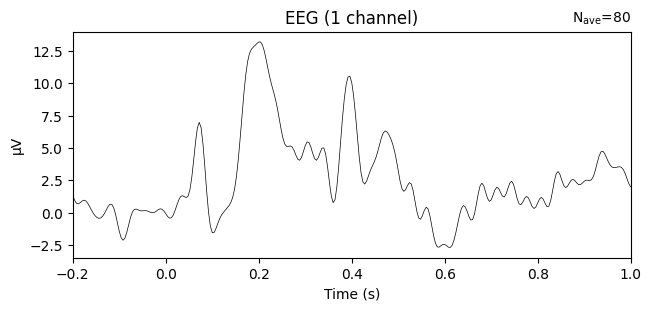

In [152]:
epochs.average().plot(picks=picks)
plt.show()

/var/folders/g2/378vjvgj0vq1r9_l6pb_nbz00000gn/T/ipykernel_32401/2421839403.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(


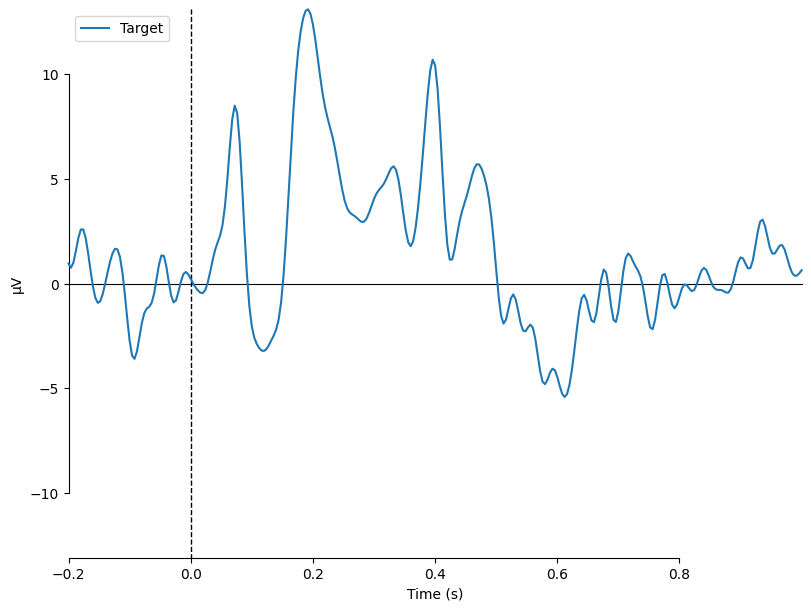

[<Figure size 800x600 with 1 Axes>]

In [153]:
mne.viz.plot_compare_evokeds(
    {"Target": epochs['face'].average()},
    # combine='mean',
    show=True
)

In [154]:
# face_epochs = epochs[faces_idx]
# car_epochs = epochs[cars_idx]

combining channels using "mean"
combining channels using "mean"


/var/folders/g2/378vjvgj0vq1r9_l6pb_nbz00000gn/T/ipykernel_32401/1620600932.py:1: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(
/var/folders/g2/378vjvgj0vq1r9_l6pb_nbz00000gn/T/ipykernel_32401/1620600932.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(


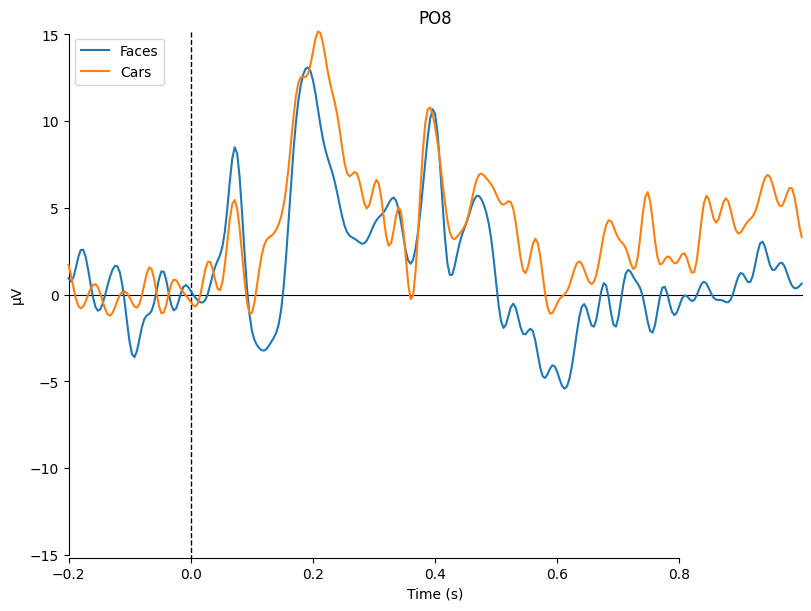

[<Figure size 800x600 with 1 Axes>]

In [155]:
mne.viz.plot_compare_evokeds(
    {"Faces": epochs['face'].average(), "Cars": epochs['car'].average()},
    picks=picks,
    combine='mean',
    show=True
)